# Task 2 : Machine-Learning Scientifique

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import pandas as pd
from torch.utils.data import DataLoader
import os

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# torch.manual_seed(42)

random_seed = 128

class Sin(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            # torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)

    model.apply(init_weights)


def fit(pinns_calss, training_set_boundary, training_set_initial, training_set_collocation, num_epochs, optimizer, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, ((inp_train_b, u_train_b), (inp_train_i, u_train_i), (inp_train_c, u_train_c)) in enumerate(zip(training_set_boundary, training_set_initial, training_set_collocation)):
            def closure():
                optimizer.zero_grad()
                loss = pinns_calss.compute_loss(inp_train_b, u_train_b, inp_train_i, u_train_i, inp_train_c, u_train_c)
                loss.backward()
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set_boundary)))
        history.append(running_loss[0])

    return history


class Pinns:
    def __init__(self):
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2, n_hidden_layers=4, neurons=20)
        torch.manual_seed(12)
        init_xavier(self.approximate_solution)

    # Function returning the training set S_tb corresponding to the temporal boundary
    def add_initial_points(self, n_initial):
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        t0 = self.domain_extrema[0, 0]
        input_initial = self.soboleng.draw(n_initial)
        # torch.random.manual_seed(random_seed)
        # input_initial = torch.rand([n_initial, 2]).type(torch.FloatTensor)
        input_initial = self.convert(input_initial)

        input_initial[:, 0] = torch.full(input_initial[:, 0].shape, t0)

        output_initial = torch.ones(input_initial.shape)

        #output_initial = (1 - input_initial[:, 1]**2).reshape(-1, 1)

        return input_initial, output_initial

    # Function returning the training set S_sb corresponding to the spatial boundary
    def add_boundary_points(self, n_boundary):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        input_boundary = self.soboleng.draw(n_boundary)
        # torch.random.manual_seed(random_seed)
        # input_boundary = torch.rand([n_boundary, 2]).type(torch.FloatTensor)
        input_boundary = self.convert(input_boundary)

        input_boundary_0 = torch.clone(input_boundary)
        input_boundary_0[:, 1] = torch.full(input_boundary_0[:, 1].shape, x0)

        input_boundary_L = torch.clone(input_boundary)
        input_boundary_L[:, 1] = torch.full(input_boundary_L[:, 1].shape, xL)

        output_boundary_0 = torch.zeros((input_boundary.shape[0], 2))
        output_boundary_0[:,0] = 3/(1+torch.exp(-200*(input_boundary_0[:,0]-0.25)))+1
        output_boundary_L = torch.zeros((input_boundary.shape[0], 2))
        return torch.cat([input_boundary_0, input_boundary_L], 0), torch.cat([output_boundary_0,output_boundary_L], 0)

    # Function returning the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_collocation_points(self, n_collocation):
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        input_collocation = self.soboleng.draw(n_collocation)
        # torch.random.manual_seed(random_seed)
        # input_collocation = torch.rand([n_collocation, 2]).type(torch.FloatTensor)
        input_collocation = self.convert(input_collocation)

        output_collocation = torch.zeros((input_collocation.shape[0], 2))
        return input_collocation, output_collocation

    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_initial, output_initial):
        pred_output_initial = self.approximate_solution(input_initial)
        # assert (pred_output_initial.shape[1] == output_initial.shape[1])
        return output_initial, pred_output_initial

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_boundary, output_boundary):
        input_boundary.requires_grad = True
        pred_output_boundary = self.approximate_solution(input_boundary)
        # pred_output_boundary.requires_grad = True
        Tf_0 = pred_output_boundary[:512,0]
        # Tf_L = pred_output_boundary[512:,0]
        # Ts_0 = pred_output_boundary[:512,1]
        # Ts_L = pred_output_boundary[512:,1]
        gradx_Ts = torch.autograd.grad(pred_output_boundary[:,0].sum(),input_boundary,create_graph=True)[0][:,1]
        gradx_Ts_0 = gradx_Ts[:512]
        gradx_Ts_L = gradx_Ts[512:]
        gradx_Tf = torch.autograd.grad(pred_output_boundary[:,1].sum(),input_boundary,create_graph=True)[0][:,1]
        # gradx_Tf_0 = gradx_Tf[:512]
        gradx_Tf_L = gradx_Tf[512:]

        Tf_boundaries = torch.cat([Tf_0,gradx_Tf_L],0)
        Ts_boundaries = torch.cat([gradx_Ts_0,gradx_Ts_L],0)
        pred_output_boundary[:,0] = Tf_boundaries
        pred_output_boundary[:,1] = Ts_boundaries

        # print(pred_output_boundary.shape)
        # assert (pred_output_boundary.shape[1] == output_boundary.shape[1])
        return output_boundary, pred_output_boundary

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_collocation):
        input_collocation.requires_grad = True
        u = self.approximate_solution(input_collocation)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xm,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxm, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dL/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dL/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        Tf = u[:,0]
        Ts = u[:,1]
        grad_Tf = torch.autograd.grad(u[:,0].sum(), input_collocation, create_graph=True)[0]
        grad_Ts = torch.autograd.grad(u[:,1].sum(), input_collocation, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:,0]
        grad_Tf_x = grad_Ts[:, 1]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_collocation, create_graph=True)[0][:, 1]

        grad_Ts_t = grad_Ts[:,0]
        grad_Ts_x = grad_Ts[:, 1]
        grad_Ts_xx = torch.autograd.grad(grad_Ts_x.sum(), input_collocation, create_graph=True)[0][:, 1]


        # Tf_t+Tf_x=0.05*Tf_xx-5(Tf-Ts)
        # Ts_t     =0.08*Ts_xx+6(Tf-Ts)
        residual = torch.zeros(u.shape)
        residual[:,0] = grad_Tf_t+grad_Tf_x-0.05*grad_Tf_xx+5*(Tf-Ts)
        residual[:,1] = grad_Ts_t-0.08*grad_Ts_xx-6*(Tf-Ts)
        return residual.reshape(-1,2)

    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])

        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def compute_loss(self, inp_train_b, u_train_b, inp_train_i, u_train_i, inp_train_c, u_train_c):
        u_train_b, u_pred_b = self.apply_boundary_conditions(inp_train_b, u_train_b)
        u_train_i, u_pred_i = self.apply_initial_condition(inp_train_i, u_train_i)

        r_int = self.compute_pde_residual(inp_train_c)  # - u_train_c.reshape(-1,)
        r_sb = u_train_b - u_pred_b
        r_tb = u_train_i - u_pred_i

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        lambda_u = 10

        loss_u = loss_sb + loss_tb
        loss = torch.log10(lambda_u * (loss_sb + loss_tb) + loss_int)
        print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    def plotting(self):
        inputs = self.soboleng.draw(10000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs)

        plt.scatter(inputs[:, 1].detach().numpy(), inputs[:, 0].detach().numpy(), c=output.detach().numpy()[:,0].T)
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Ts")

        plt.show()

        plt.scatter(inputs[:, 1].detach().numpy(), inputs[:, 0].detach().numpy(), c=output.detach().numpy()[:,1].T)
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Tf")

        plt.show()

In [4]:
n_init = 1024
n_bound = 512
n_coll = 8192

pinn = Pinns()
# Generate S_sb, S_tb, S_int
input_b_, output_b_ = pinn.add_boundary_points(n_bound)  # S_sb
input_i_, output_i_ = pinn.add_initial_points(n_init)  # S_tb
input_c_, output_c_ = pinn.add_collocation_points(n_coll)  # S_int

training_set_b = DataLoader(torch.utils.data.TensorDataset(input_b_, output_b_), batch_size=2 * n_bound, shuffle=False)
training_set_i = DataLoader(torch.utils.data.TensorDataset(input_i_, output_i_), batch_size=n_init, shuffle=False)
training_set_c = DataLoader(torch.utils.data.TensorDataset(input_c_, output_c_), batch_size=n_coll, shuffle=False)

n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(), lr=float(0.5), max_iter=1000, max_eval=50000, history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
hist = fit(pinn, training_set_b, training_set_i, training_set_c, num_epochs=n_epochs, optimizer=optimizer_LBFGS, verbose=True)

################################  0  ################################
Total loss:  2.5453 | PDE Loss:  1.1146 | Function Loss:  2.344
Total loss:  2.4804 | PDE Loss:  1.0791 | Function Loss:  2.2608
Total loss:  2.1108 | PDE Loss:  0.8956 | Function Loss:  1.7028
Total loss:  2.927 | PDE Loss:  0.7734 | Function Loss:  2.8953
Total loss:  1.8527 | PDE Loss:  0.6152 | Function Loss:  1.4774
Total loss:  1.7447 | PDE Loss:  0.6697 | Function Loss:  0.945
Total loss:  1.6541 | PDE Loss:  0.6067 | Function Loss:  0.669
Total loss:  1.5314 | PDE Loss:  0.4923 | Function Loss:  0.4673
Total loss:  1.5605 | PDE Loss:  0.4932 | Function Loss:  0.7176
Total loss:  1.4877 | PDE Loss:  0.4589 | Function Loss:  0.2955
Total loss:  1.4407 | PDE Loss:  0.419 | Function Loss:  0.1281
Total loss:  1.2493 | PDE Loss:  0.106 | Function Loss:  0.6982
Total loss:  1.2089 | PDE Loss:  0.0743 | Function Loss:  0.6347
Total loss:  1.1652 | PDE Loss:  0.0836 | Function Loss:  0.3991
Total loss:  1.1086 | PDE 

## Test de notre réseau sur les données

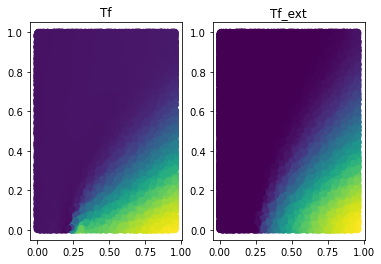

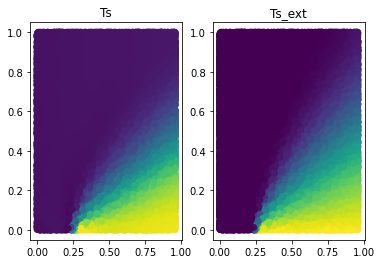

rel error Tf: 11.56%
rel error Ts: 7.42%


In [12]:
exact_sol = pd.read_csv("./exact_solution.txt",sep=" ")
exact_sol = torch.Tensor(exact_sol.values)

t = exact_sol[:,0]
x = exact_sol[:,1]
input = exact_sol[:,:2]
Ts_ext = exact_sol[:,2]
Tf_ext = exact_sol[:,3]
sol = pinn.approximate_solution(input)
Ts = sol[:,0]
Tf = sol[:,1]

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.scatter(t,x,c=Tf.detach().numpy())
ax1.set_title("Tf")
ax2.scatter(t,x,c=Tf_ext.detach().numpy())
ax2.set_title("Tf_ext")
plt.show()

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.scatter(t,x,c=Ts.detach().numpy())
ax1.set_title("Ts")
ax2.scatter(t,x,c=Ts_ext.detach().numpy())
ax2.set_title("Ts_ext")
plt.show()

rel_err_Tf = np.linalg.norm((Tf-Tf_ext).detach().numpy())/np.linalg.norm(Tf_ext.detach().numpy())
rel_err_Ts = np.linalg.norm((Ts-Ts_ext).detach().numpy())/np.linalg.norm(Ts_ext.detach().numpy())
print(f"rel error Tf: {rel_err_Tf*100:.2f}%")
print(f"rel error Ts: {rel_err_Ts*100:.2f}%")



## On sauvegarde les données en .txt

In [18]:
data = np.concatenate((t.view((-1,1)).detach().numpy(),x.view((-1,1)).detach().numpy(),Tf.view((-1,1)).detach().numpy(),Ts.view((-1,1)).detach().numpy()),axis=1)
np.savetxt("Task2.txt",data,header="t x Tf Ts")